In [80]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import collections
import ipynb.fs.full.Structural_Perturbations as SP
import ipynb.fs.full.MultiTest as MT
tf.logging.set_verbosity(tf.logging.ERROR)
import sys

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


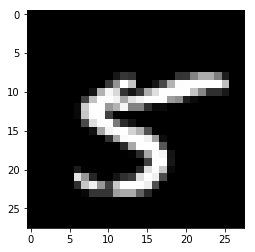

In [266]:
train_data,train_labels,eval_data,eval_labels = SP.load(data='mnist')
SP.Display(eval_data,433)

In [16]:
eval_data = SP.Scaling(eval_data,.8)

In [18]:
eval_data = Exposure(eval_data,+60)

In [46]:
eval_data = Rotation(eval_data,10)

In [69]:
eval_data = Translation(eval_data,2)

In [267]:
data = np.empty([train_data.shape[0],train_data.shape[1]+1])
for i in range (0,data.shape[0]):
    data[i] = np.append(train_data[i],int(train_labels[i]))
data = data[data[:,784].argsort()]
a = 0.0
count=[]
for i in range (0,data.shape[0]):
    if data[i,784]!= a:
        count.append(i)
        a += 1
count.append(data.shape[0]-1)
count = np.array(count)
a = 0
digit = []
s = 0
while a!=count.shape[0]:
    digit.append(data[s:count[a]])
    s = count[a]
    a +=1
digit = np.array(digit)
for i in range(0,digit.shape[0]):
    digit[i] = np.delete(digit[i],[784], axis=1)

In [268]:
print(digit[5].shape)

(4987, 784)


In [269]:
samples = 15
ref = np.empty([8*samples,784])
cur = samples
prev = 0
for i in range(0,10):
    if i==6 or i==9:
        continue
    s = digit[i].shape[0]
    p = np.random.choice(s, samples, replace=False)
    for j in range(prev,cur):
        ref[j] = digit[i][p[j%samples]]
    prev = cur
    cur +=samples
print(ref.shape)

(120, 784)


In [270]:
database = []#np.empty(784)
rot = [0,45,90,135,180,225,270,315]
for j in rot:
    o = SP.Rotation(ref,j)
    for k in o:
        database.append(k)

In [271]:
database = np.array(database)
print(database.shape)

(960, 784)


In [272]:
temp =[]
for i in database:
    temp.append(cv2.flip(i,flipCode=1))

In [273]:
temp = np.array(temp)
temp.shape

(960, 784, 1)

In [274]:
temp = temp.reshape(temp.shape[0],temp.shape[1])

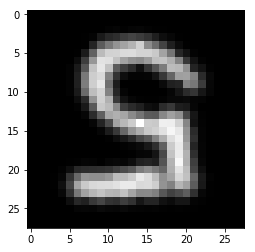

In [277]:
SP.Display(database,322)

In [278]:
database = np.concatenate((database,temp))

In [279]:
database.shape

(2880, 784)

In [280]:
train_data = np.float32(database)
train_labels = np.zeros(database.shape[0],dtype=np.int32)
label = [0,1,2,3,4,5,7,8]
c = 0
for o in range (0,2):
    for p in range (0,8):
        for i in range (0,8):
            for j in range(0,samples):
                train_labels[c] = label[i]
                c+=1

In [281]:
temp = np.random.randint(0,10000,500)

In [282]:
eval_data.shape

(10000, 784)

In [283]:
evald = []
evall = []
for i in temp:
    if eval_labels[i]== 6 or eval_labels[i]==9 :
        continue
    evald.append(eval_data[i])
    evall.append(eval_labels[i])

In [284]:
eval_data,eval_labels = np.array(evald),np.array(evall)

4


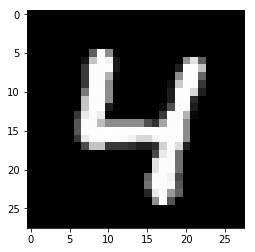

In [285]:
p = 3
SP.Display(eval_data,p)
print(eval_labels[p])

In [286]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=8,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=16,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 16])

    dense = tf.layers.dense(inputs=pool2_flat, units=120, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)

        #"classes": temp,
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(
            mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy":
        tf.metrics.accuracy(labels=labels, predictions=predictions["classes"]),
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [290]:
# Evaluate the model and print results
mnist_classifier = tf.estimator.Estimator(
  model_fn=cnn_model_fn, model_dir="./models/mnist_convnet_model_tiny13")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=50)

In [291]:
def current_loss(flag):
    train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      shuffle=False)
    eval_result1=mnist_classifier.evaluate(input_fn=train_eval_input_fn)
    if flag:
        print("%%%%%%% Train accuracy %%%%%%%%%%%%\n",eval_result1)
    [a,b,c] = eval_result1.items()

    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    eval_result2=mnist_classifier.evaluate(input_fn=eval_input_fn)
    if flag:
        print("######### Test accuracy #############\n",eval_result2)
    [d,e,f] = eval_result2.items()
    return a[1],d[1]

In [292]:
print("started\n")
# Train the model
while 1:
    
# Train the model
    print("Training")
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=256,
      num_epochs=None,
      shuffle=True)

    mnist_classifier.train(
      input_fn=train_input_fn,
      steps=1000,
      hooks=[logging_hook])
    curr_result = current_loss(0)
    print(curr_result)
#     if curr_result[0] - curr_result[1] > 0.10 or curr_result[1] > 0.98:
#        break
    #print(curr_result)
    
print ("Finished")

started

Training
(0.7083333, 0.27518427)
Training
(0.7083333, 0.27272728)
Training


KeyboardInterrupt: 

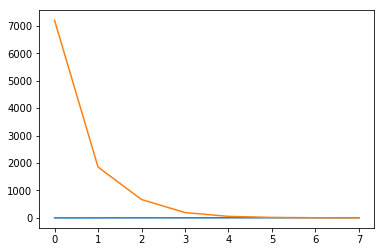

In [9]:
Plot(eval_data,eval_labels,mnist_classifier)

In [230]:
SP.Test(train_data,train_labels,eval_data,eval_labels,mnist_classifier)

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9483333, 'loss': 0.1752593, 'global_step': 600}
######### Test accuracy #############
 {'accuracy': 0.41625616, 'loss': 3.12212, 'global_step': 600}


In [167]:
%%capture
a = []
t = [0,15,30,45,60,90,135,180,225,275]
for i in t:
    g = np.copy(eval_data)
    eval_data_temp = SP.Rotation(g,i)
    a.append(SP.Test(train_data,train_labels,eval_data_temp,eval_labels,mnist_classifier,1)[3])

In [168]:
a = np.array(a)
a = a.T

In [182]:
b = []
for i in range(0,a.shape[1]):
    b.append((t[i],a[1][i]))
print(b)

[(0, '0.7067308'), (15, '0.63461536'), (30, '0.44230768'), (45, '0.22836539'), (60, '0.16346154'), (90, '0.125'), (135, '0.17548077'), (180, '0.31490386'), (225, '0.16586539'), (275, '0.14903846')]
